In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import sys
import copy
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.tree import DecisionTreeClassifier
import sklearn.datasets as datasets
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import seaborn as sns
import geopandas as gpd
from ExKMC.Tree import Tree as ExTree
from ExKMC.splitters import get_min_mistakes_cut, get_min_surrogate_cut


sys.path.append("../main")
from tree import *
from rule_clustering import *
from utils import *
from experiments import *

%load_ext autoreload
%autoreload 2

In [2]:
# set the seed 
seed = 13982
np.random.seed(seed)

In [3]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 14
})

colorblind_palette = sns.color_palette("colorblind", as_cmap=False)
cmap = ListedColormap(colorblind_palette)
subset_colors = [cmap(0), cmap(4), cmap(9)]
cmap_subset = ListedColormap(subset_colors)
#subset_colors2 = [cmap(0), cmap(2), cmap(5), cmap(4), cmap(8), cmap(9),]
subset_colors2 = [cmap(0), cmap(2), cmap(9), cmap(4), cmap(7), cmap(8),]
cmap_subset2 = ListedColormap(subset_colors2)

### Iris

In [25]:
iris, iris_labels = datasets.load_iris(return_X_y=True)
k = 3

scaler = MinMaxScaler()

X = scaler.fit_transform(iris)

In [26]:
pd.DataFrame(X)

,0,1,2,3
0,0.222222,0.625000,0.067797,0.041667
1,0.166667,0.416667,0.067797,0.041667
2,0.111111,0.500000,0.050847,0.041667
3,0.083333,0.458333,0.084746,0.041667
4,0.194444,0.666667,0.067797,0.041667
...,...,...,...,...
145,0.666667,0.416667,0.711864,0.916667
146,0.555556,0.208333,0.677966,0.750000
147,0.611111,0.416667,0.711864,0.791667
148,0.527778,0.583333,0.745763,0.916667


### Wine

In [36]:
wine, wine_labels = datasets.load_wine(return_X_y=True)
k = 3

scaler = MinMaxScaler()

X = scaler.fit_transform(wine)

In [37]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341
1,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642
2,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933
3,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.664557,0.207547,0.558360,0.556314,0.308943,0.798535,0.857347
4,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.495781,0.490566,0.444795,0.259386,0.455285,0.608059,0.325963
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,0.705263,0.970356,0.582888,0.510309,0.271739,0.241379,0.056962,0.735849,0.205047,0.547782,0.130081,0.172161,0.329529
174,0.623684,0.626482,0.598930,0.639175,0.347826,0.282759,0.086498,0.566038,0.315457,0.513652,0.178862,0.106227,0.336662
175,0.589474,0.699605,0.481283,0.484536,0.543478,0.210345,0.073840,0.566038,0.296530,0.761092,0.089431,0.106227,0.397290
176,0.563158,0.365613,0.540107,0.484536,0.543478,0.231034,0.071730,0.754717,0.331230,0.684300,0.097561,0.128205,0.400856


### Breast Cancer

In [6]:
breast_cancer, breast_cancer_labels = datasets.load_breast_cancer(return_X_y=True)
k = 2

scaler = MinMaxScaler()

X = scaler.fit_transform(breast_cancer)

In [7]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,0.605518,...,0.620776,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864
1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323,...,0.606901,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878
2,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,0.211247,...,0.556386,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433
3,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,1.000000,...,0.248310,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711
4,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,0.186816,...,0.519744,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0.690000,0.428813,0.678668,0.566490,0.526948,0.296055,0.571462,0.690358,0.336364,0.132056,...,0.623266,0.383262,0.576174,0.452664,0.461137,0.178527,0.328035,0.761512,0.097575,0.105667
565,0.622320,0.626987,0.604036,0.474019,0.407782,0.257714,0.337395,0.486630,0.349495,0.113100,...,0.560655,0.699094,0.520892,0.379915,0.300007,0.159997,0.256789,0.559450,0.198502,0.074315
566,0.455251,0.621238,0.445788,0.303118,0.288165,0.254340,0.216753,0.263519,0.267677,0.137321,...,0.393099,0.589019,0.379949,0.230731,0.282177,0.273705,0.271805,0.487285,0.128721,0.151909
567,0.644564,0.663510,0.665538,0.475716,0.588336,0.790197,0.823336,0.755467,0.675253,0.425442,...,0.633582,0.730277,0.668310,0.402035,0.619626,0.815758,0.749760,0.910653,0.497142,0.452315


### Digits

In [88]:
digits, digit_labels = datasets.load_digits(return_X_y=True)
k = 10

scaler = MinMaxScaler()

X = scaler.fit_transform(digits)

In [89]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,0.3125,0.8125,0.5625,0.0625,0.0000,0.0,0.0,0.0000,...,0.0000,0.0,0.0,0.000000,0.3750,0.8125,0.6250,0.0000,0.0000,0.0
1,0.0,0.0,0.0000,0.7500,0.8125,0.3125,0.0000,0.0,0.0,0.0000,...,0.0000,0.0,0.0,0.000000,0.0000,0.6875,1.0000,0.6250,0.0000,0.0
2,0.0,0.0,0.0000,0.2500,0.9375,0.7500,0.0000,0.0,0.0,0.0000,...,0.3125,0.0,0.0,0.000000,0.0000,0.1875,0.6875,1.0000,0.5625,0.0
3,0.0,0.0,0.4375,0.9375,0.8125,0.0625,0.0000,0.0,0.0,0.5000,...,0.5625,0.0,0.0,0.000000,0.4375,0.8125,0.8125,0.5625,0.0000,0.0
4,0.0,0.0,0.0000,0.0625,0.6875,0.0000,0.0000,0.0,0.0,0.0000,...,0.0000,0.0,0.0,0.000000,0.0000,0.1250,1.0000,0.2500,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,0.0,0.0,0.2500,0.6250,0.8125,0.3750,0.0000,0.0,0.0,0.0625,...,0.2500,0.0,0.0,0.000000,0.1250,0.8750,0.9375,0.5625,0.0000,0.0
1793,0.0,0.0,0.3750,1.0000,0.8125,0.6875,0.0625,0.0,0.0,0.0000,...,0.0625,0.0,0.0,0.000000,0.3750,1.0000,0.8750,0.3750,0.0000,0.0
1794,0.0,0.0,0.0625,0.6875,0.9375,0.0625,0.0000,0.0,0.0,0.0000,...,0.0000,0.0,0.0,0.000000,0.1250,0.5625,0.8125,0.3750,0.0000,0.0
1795,0.0,0.0,0.1250,0.6250,0.4375,0.0000,0.0000,0.0,0.0,0.0000,...,0.1250,0.0,0.0,0.000000,0.3125,0.7500,1.0000,0.7500,0.0000,0.0


### Mice Protein

In [86]:
mice_protein = pd.read_csv('../data/mice_protein/Data_Cortex_Nuclear.csv', index_col = 0)
mice_protein = mice_protein.iloc[:, :-4]
mice_protein = mice_protein.to_numpy()

k = 8

# Remove Features which are mostly NaNs:
nan_proportion = np.mean(np.isnan(mice_protein), axis=0)
threshold = 0.1
keep = nan_proportion < threshold
mice_protein = mice_protein[:,keep]

# Get rid of any rows with have NaNs remaining:
mask = ~np.isnan(mice_protein).any(axis=1)
mice_protein = mice_protein[mask,:] 

scaler = MinMaxScaler()

X = scaler.fit_transform(mice_protein)

In [87]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,0.151122,0.212885,0.824638,0.612119,0.630482,0.311935,0.333862,0.168257,0.617322,0.232553,...,0.432843,0.445345,0.000255,0.256699,0.405228,0.162941,0.426816,0.133930,0.336299,0.705738
1,0.155750,0.188226,0.776455,0.601070,0.585247,0.288997,0.311188,0.154925,0.590173,0.205362,...,0.472327,0.438745,0.010389,0.226088,0.433471,0.220010,0.429952,0.110434,0.365208,0.749771
2,0.153459,0.205696,0.793572,0.558911,0.575910,0.280626,0.325060,0.153485,0.607102,0.199194,...,0.467603,0.446602,0.000000,0.214719,0.429387,0.186816,0.448652,0.121560,0.353621,0.868229
3,0.125169,0.157688,0.637326,0.468152,0.480646,0.324867,0.328596,0.132074,0.486945,0.205135,...,0.364359,0.408299,0.078216,0.208943,0.407971,0.179047,0.392700,0.151031,0.265619,0.721879
4,0.122146,0.157838,0.637787,0.426467,0.441977,0.293683,0.315055,0.129086,0.410194,0.189152,...,0.393332,0.441639,0.075815,0.215528,0.480342,0.245702,0.410187,0.147711,0.350381,0.812053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,0.046197,0.092577,0.365672,0.313684,0.127872,0.289314,0.303762,0.186230,0.488562,0.110645,...,0.271418,0.807299,0.394762,0.445678,0.614708,0.591238,0.530654,0.572176,0.230480,0.504334
968,0.053509,0.097062,0.357235,0.342243,0.157739,0.415382,0.357408,0.190968,0.535204,0.114722,...,0.243750,0.779213,0.410897,0.439766,0.647788,0.629077,0.506703,0.527466,0.232818,0.504110
969,0.035163,0.063556,0.311370,0.165795,0.071655,0.317786,0.256836,0.105509,0.374040,0.080099,...,0.337187,0.785748,0.478488,0.428755,0.636498,0.666803,0.565002,0.425904,0.326363,0.547100
970,0.032018,0.071071,0.337173,0.224787,0.095856,0.280262,0.315038,0.121245,0.409605,0.086829,...,0.372550,0.827688,0.514263,0.480060,0.656710,0.745142,0.634370,0.647984,0.277565,0.529739


### Anuran

In [84]:
anuran = pd.read_csv('../data/anuran/Frogs_MFCCs.csv')
anuran = anuran.iloc[:, :-4]
anuran = anuran.to_numpy()

k = 10

scaler = MinMaxScaler()

X = scaler.fit_transform(anuran)

In [85]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,1.0,0.493693,0.230108,0.457262,0.686625,0.488253,0.415812,0.377963,0.314020,0.730114,...,0.306751,0.576802,0.615338,0.405908,0.283982,0.496364,0.534822,0.505537,0.669615,0.484704
1,1.0,0.504810,0.234712,0.503234,0.702091,0.493774,0.389749,0.313783,0.286431,0.761439,...,0.245168,0.525813,0.635227,0.436727,0.299741,0.511737,0.514315,0.460275,0.625237,0.503209
2,1.0,0.493323,0.245855,0.515934,0.656957,0.436679,0.355882,0.296270,0.277784,0.803239,...,0.255835,0.549828,0.666985,0.497882,0.336274,0.535706,0.489280,0.405755,0.645765,0.562490
3,1.0,0.536404,0.386491,0.544660,0.726162,0.561174,0.360292,0.338713,0.369060,0.828890,...,0.205703,0.496354,0.589842,0.383497,0.258898,0.423977,0.438460,0.369970,0.502213,0.496923
4,1.0,0.454770,0.256042,0.529406,0.696509,0.479800,0.354693,0.275717,0.312834,0.826219,...,0.217377,0.538379,0.675508,0.480182,0.337913,0.514239,0.471886,0.398205,0.657343,0.565055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7190,1.0,0.070843,0.068460,0.345093,0.482996,0.621150,0.411227,0.421667,0.471122,0.700554,...,0.313524,0.455366,0.534862,0.425709,0.445214,0.604581,0.559651,0.499227,0.498351,0.368996
7191,1.0,0.093096,0.045580,0.341792,0.507189,0.591643,0.413007,0.407745,0.491223,0.705950,...,0.301568,0.415717,0.539596,0.431968,0.437684,0.603108,0.556587,0.492008,0.506202,0.341846
7192,1.0,0.054075,0.064616,0.340974,0.504367,0.579063,0.424883,0.419394,0.496235,0.700718,...,0.310783,0.438858,0.535335,0.433882,0.457044,0.609510,0.534727,0.469551,0.524344,0.368299
7193,1.0,0.091767,0.089465,0.317622,0.510624,0.572905,0.406664,0.408331,0.486131,0.706141,...,0.308837,0.441684,0.533922,0.428092,0.429222,0.603177,0.556760,0.486392,0.490978,0.348004


### Synthetic

In [106]:
k = 3
n = 5000
d = 1000
X = np.zeros((n,d))

v = 1000
X[0,:] = np.concatenate(([v], np.zeros(d - 1) + 1))
X[1,:] = np.concatenate(([v], np.zeros(d - 1)))


mid = (d - 2)//2 + 2
for i in range(2,mid):
    x = np.zeros(d - 1) + 1
    rand = np.random.choice(range(d-1), 100, replace = False)
    x[rand] = 0
    X[i,:] = np.concatenate(([0], x))
    
for i in range(mid, n):
    x = np.zeros(d - 1)
    rand = np.random.choice(range(d-1), 100, replace = False)
    x[rand] = 1
    X[i,:] = np.concatenate(([0], x))

### Run Experiment

In [40]:
exp = Experiment(data = X, n_clusters = k, random_seed = seed, verbose = True)
exp.initialize()

Initializing k-means
Initializing IMM
Initializing Randomized IMM


In [41]:
exp.run_leaves_cost(min_leaves = k, max_leaves = 32, clusterer = KMeansRuleClustering)

Initializing trees...
Number of leaves: 3
Number of leaves: 4
Number of leaves: 5
Number of leaves: 6
Number of leaves: 7
Number of leaves: 8
Number of leaves: 9
Number of leaves: 10
Number of leaves: 11
Number of leaves: 12
Number of leaves: 13
Number of leaves: 14
Number of leaves: 15
Number of leaves: 16
Number of leaves: 17
Number of leaves: 18
Number of leaves: 19
Number of leaves: 20
Number of leaves: 21
Number of leaves: 22
Number of leaves: 23
Number of leaves: 24
Number of leaves: 25
Number of leaves: 26
Number of leaves: 27
Number of leaves: 28
Number of leaves: 29
Number of leaves: 30
Number of leaves: 31
Number of leaves: 32


In [42]:
exp.run_depths_cost(min_depth = 2, max_depth = 8, max_leaves = 32, clusterer = KMeansRuleClustering)

Depth: 2
Depth: 3
Depth: 4
Depth: 5
Depth: 6
Depth: 7
Depth: 8


In [43]:
directory = '../data/experiments/wine/'
identifier = ''
exp.save_results(directory,identifier)

In [14]:
directory = '../data/experiments/anuran/'
identifier = ''

leaves_cost_filename = os.path.join(directory, 'leaves_cost' + str(identifier) + '.csv')
leaves_depth_filename = os.path.join(directory, 'leaves_depth' + str(identifier) + '.csv')
leaves_iteration_filename = os.path.join(directory, 'leaves_iteration' + str(identifier) + '.csv')
depth_cost_filename = os.path.join(directory, 'depths_cost' + str(identifier) +  '.csv')

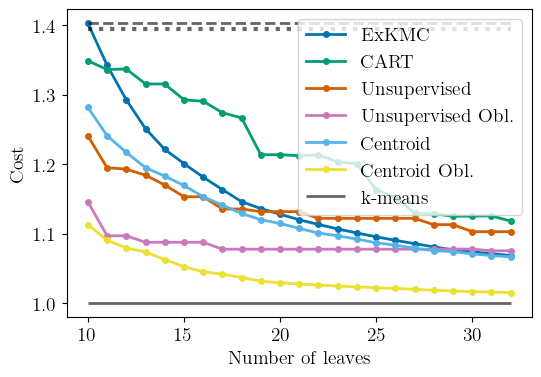

In [15]:
fig,ax = plt.subplots(figsize = (6,4))

leaves_cost_df = pd.read_csv(leaves_cost_filename, index_col = 0)
cost = leaves_cost_df['k-means'].iloc[0]
imm_cost = leaves_cost_df['IMM'].iloc[0]
random_imm_cost = leaves_cost_df['RandomIMM'].iloc[0]
leaves = leaves_cost_df.index 

ax.plot(leaves, np.array(leaves_cost_df['ExKMC'])/cost, linewidth = 2, marker='o', markersize = 4, label = 'ExKMC', c = cmap(0))
ax.plot(leaves, np.array(leaves_cost_df['CART'])/cost, linewidth = 2, marker='o', markersize = 4, label = 'CART', c = cmap(2))
ax.plot(leaves, np.array(leaves_cost_df['Unsupervised'])/cost, linewidth = 2, marker='o', markersize = 4, label = 'Unsupervised', c = cmap(3))
ax.plot(leaves, np.array(leaves_cost_df['Unsupervised Obl.'])/cost, linewidth = 2, marker='o', markersize = 4, label = 'Unsupervised Obl.', c = cmap(4))
ax.plot(leaves, np.array(leaves_cost_df['Centroid'])/cost, linewidth = 2, marker='o', markersize = 4, label = 'Centroid', c = cmap(9))
ax.plot(leaves, np.array(leaves_cost_df['Centroid Obl.'])/cost, linewidth = 2, marker='o', markersize = 4, label = 'Centroid Obl.', c = cmap(8))
#ax.plot(leaves, np.array(leaves_cost_df['Hybrid'])/cost, linewidth = 2, marker='o', markersize = 4, label = 'Hybrid', c = cmap(1))
#ax.plot(leaves, np.array(leaves_cost_df['Hybrid Obl.'])/cost, linewidth = 2, marker='o', markersize = 4, label = 'Hybrid Obl.', c = cmap(6))

ax.hlines(random_imm_cost/cost, xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = 'dotted', linewidth = 3, alpha = 0.6)
ax.hlines(imm_cost/cost, xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = '--', linewidth = 2, alpha = 0.6)
ax.hlines(cost/cost, xmin = leaves[0], xmax = leaves[-1], color = 'k', label = 'k-means', linestyle = '-', linewidth = 2, alpha = 0.6)

plt.legend(loc = 'upper right')
ax.set_xlabel('Number of leaves')
ax.set_ylabel('Cost')
plt.savefig('figures/anuran/leaves_cost_compare.jpg', bbox_inches = 'tight', dpi = 300)

Text(0, 0.5, 'Depth')

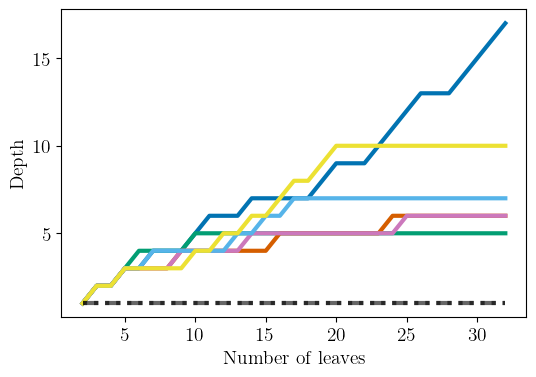

In [15]:
fig,ax = plt.subplots(figsize = (6,4))

data_df = pd.read_csv(leaves_depth_filename, index_col = 0)
imm_depth = data_df['IMM'].iloc[0]
random_imm_depth = data_df['RandomIMM'].iloc[0]
leaves = data_df.index 

ax.plot(leaves, np.array(data_df['ExKMC']), linewidth = 3, label = 'ExKMC', c = cmap(0))
ax.plot(leaves, np.array(data_df['CART']), linewidth = 3, label = 'CART', c = cmap(2))
ax.plot(leaves, np.array(data_df['Unsupervised']), linewidth = 3, label = 'Unsupervised', c = cmap(3))
ax.plot(leaves, np.array(data_df['Unsupervised Obl.']), linewidth = 3, label = 'Unsupervised Obl.', c = cmap(4))
ax.plot(leaves, np.array(data_df['Centroid']), linewidth = 3, label = 'Centroid', c = cmap(9))
ax.plot(leaves, np.array(data_df['Centroid Obl.']), linewidth = 3, label = 'Centroid Obl.', c = cmap(8))
#ax.plot(leaves, np.array(data_df['Hybrid']), linewidth = 3, label = 'Hybrid', c = cmap(1))
#ax.plot(leaves, np.array(data_df['Hybrid Obl.']), linewidth = 3, label = 'Hybrid Obl.', c = cmap(6))

ax.hlines(random_imm_depth, xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = 'dotted', label = 'RandomIMM', linewidth = 3, alpha = 0.6)
ax.hlines(imm_depth, xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = '--', label = 'IMM', linewidth = 3, alpha = 0.6)

#plt.legend(loc = 'upper left')
ax.set_xlabel('Number of leaves')
ax.set_ylabel('Depth')

Text(0, 0.5, 'Clustering Iterations')

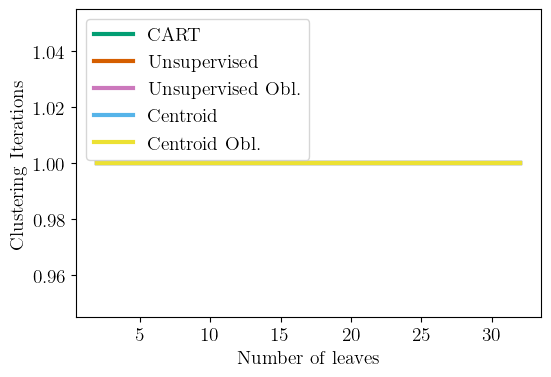

In [16]:
fig,ax = plt.subplots(figsize = (6,4))

data_df = pd.read_csv(leaves_iteration_filename, index_col = 0)
leaves = data_df.index 

ax.plot(leaves, np.array(data_df['CART']), linewidth = 3, label = 'CART', c = cmap(2))
ax.plot(leaves, np.array(data_df['Unsupervised']), linewidth = 3, label = 'Unsupervised', c = cmap(3))
ax.plot(leaves, np.array(data_df['Unsupervised Obl.']), linewidth = 3, label = 'Unsupervised Obl.', c = cmap(4))
ax.plot(leaves, np.array(data_df['Centroid']), linewidth = 3, label = 'Centroid', c = cmap(9))
ax.plot(leaves, np.array(data_df['Centroid Obl.']), linewidth = 3, label = 'Centroid Obl.', c = cmap(8))
#ax.plot(leaves, np.array(data_df['Hybrid']), linewidth = 3, label = 'Hybrid', c = cmap(1))
#ax.plot(leaves, np.array(data_df['Hybrid Obl.']), linewidth = 3, label = 'Hybrid Obl.', c = cmap(6))

plt.legend(loc = 'upper left')
ax.set_xlabel('Number of leaves')
ax.set_ylabel('Clustering Iterations')

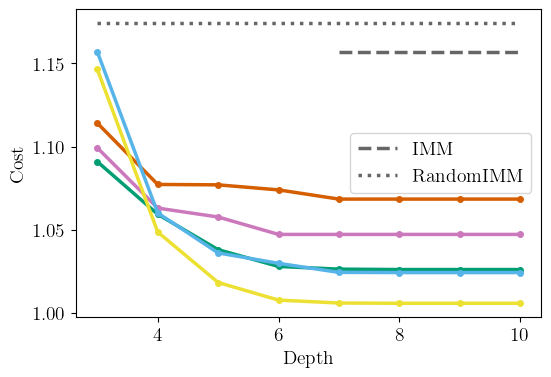

In [13]:
fig,ax = plt.subplots(figsize = (6,4))

depths_cost_df = pd.read_csv(depth_cost_filename, index_col = 0)
imm_cost = leaves_cost_df['IMM'].iloc[0]
random_imm_cost = leaves_cost_df['RandomIMM'].iloc[0]
depths = depths_cost_df.index 

ax.plot(depths, np.array(depths_cost_df['CART'])/cost, linewidth = 2.5, marker='o', markersize = 4, c = cmap(2))
ax.plot(depths, np.array(depths_cost_df['Unsupervised'])/cost, linewidth = 2.5, marker='o', markersize = 4, c = cmap(3))
ax.plot(depths, np.array(depths_cost_df['Unsupervised Obl.'])/cost, linewidth = 2.5, marker='o', markersize = 4, c = cmap(4))
ax.plot(depths, np.array(depths_cost_df['Centroid'])/cost, linewidth = 2.5, marker='o', markersize = 4, c = cmap(9))
ax.plot(depths, np.array(depths_cost_df['Centroid Obl.'])/cost, linewidth = 2.5, marker='o', markersize = 4, c = cmap(8))
#ax.plot(depths, np.array(depths_cost_df['Hybrid'])/cost, linewidth = 2.5, marker='o', markersize = 4, c = cmap(1))
#ax.plot(depths, np.array(depths_cost_df['Hybrid Obl.'])/cost, linewidth = 2.5, marker='o', markersize = 4, c = cmap(6))

ax.plot(depths, np.array(depths_cost_df['IMM'])/cost, linewidth = 2.5, label = 'IMM', c = 'k', linestyle = '--', alpha = 0.6)
ax.plot(depths, np.array(depths_cost_df['RandomIMM'])/cost, linewidth = 2.5, label = 'RandomIMM', c = 'k', linestyle = 'dotted', alpha = 0.6)
#ax.hlines(exp.imm_cost/cost, xmin = exp.imm_depth, xmax = depths[-1], color = 'k', linestyle = '--', label = 'IMM', linewidth = 2, alpha = 0.6)
#ax.hlines(cost/cost, xmin = depths[0], xmax = depths[-1], color = 'k', linestyle = '-', label = 'k-means', linewidth = 2, alpha = 0.6)

plt.legend(loc = 'center right')
ax.set_xlabel('Depth')
ax.set_ylabel('Cost')
plt.savefig('figures/mice_protein/depth_cost_compare.jpg', bbox_inches = 'tight', dpi = 300)